## Image convolution for edge detection

Convolution is a central operation in image processing, where the image is filtered with a kernel (also called filter or convolution matrix).
Depending on the kernel that is used, we can e.g. blur or sharpen the images or detect edges.

In the following we use the sobel-v filter to detect vertical edges in an image. The operation is defined as

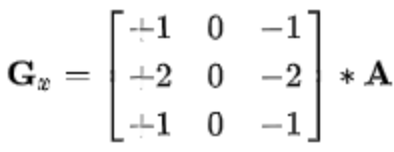,

where the Sobel filter S<sub>x</sub> in x-direction is convolved with the image A resulting in the approximate gradient G<sub>x</sub> in x-direction.


### Context

Moreover, one can calculate the gradient in vertical direction as well

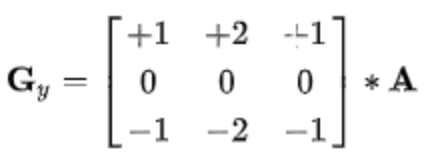

and obtain the magnitude of the gradient at each pixel as:

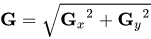

## Implementation

Generally, the discrete convolution is computed as

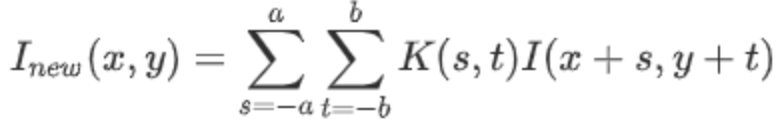,

where K(s,t) is the kernel, I(x,y) is the original and image I<sub>new</sub>(x,y) is the resulting filtered image. In our case, for the Sobel-filter K has shape 3x3.  Each pixel in I<sub>new</sub>(x,y) is the result of the sum over all neighborhood-pixels multiplied (weighted) with its corresponding filter value.

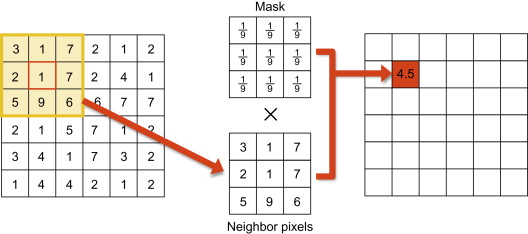

Since we perform the identical operation for each pixel (with fixed kernel values), this operation can run in parallel for each pixel on GPU.

Sources: [1](https://www.sciencedirect.com/topics/computer-science/linear-convolution)

### Scikit-Image version

1.24 s ± 19 ms per loop (mean ± std. dev. of 10 runs, 2 loops each)
min pixel value: -0.87254906
max pixel value: 0.9196078


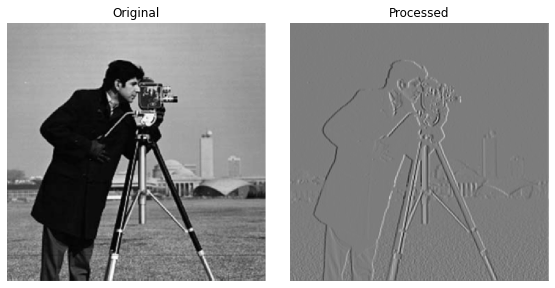

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, io

# read image and normalize
image = io.imread("../codes/image_processing/sobel_v_convolution/photographer.png").astype(np.float32)
# image = io.imread("photographer.png").astype(np.float32)
image = np.tile(image, (20, 20))
image -= np.min(image)
image /= np.max(image)

# filter vertical edges with sobel_v
resGPU = %timeit -n 2 -r 10 -o edges_sobel_v = filters.sobel_v(image)

# print min- and max-values for comparison with reference implementation
print("min pixel value: " + str(np.min(edges_sobel_v)))
print("max pixel value: " + str(np.max(edges_sobel_v)))

# show images
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 4))
axes[0].imshow(image, cmap=plt.cm.gray)
axes[0].set_title('Original')
axes[1].imshow(edges_sobel_v, cmap=plt.cm.gray)
axes[1].set_title('Processed')
for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()


### CUDA implementation

In [3]:
from numba import cuda

# kernel definition
@cuda.jit
def filter2d_gpu(image, filt, result):
    image_height, image_width = image.shape
    filter_height, filter_width = filt.shape
    filter_height_halved = filter_height // 2
    filter_width_halved = filter_width // 2

    row = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
    col = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x

    if (row > filter_height_halved and row < image_height - filter_height_halved):
        if (col > filter_width_halved and col < image_width - filter_width_halved):
            sum = 0.0
            for conv_index_y in range(-filter_height_halved, filter_height_halved + 1):
                for conv_index_x in range(-filter_width_halved, filter_width_halved + 1):
                    kernelCoord = filter_height_halved + conv_index_y, filter_width_halved + conv_index_x
                    imageCoord = row + conv_index_y, col + conv_index_x
                    sum += filt[kernelCoord] * image[imageCoord]
            result[row, col] = sum

In [6]:
# from numba import jit, autojit, prange
from numba import jit

# kernel definition
@jit(nopython=True, parallel=True)
def filter2d_cpu(image, filt, result):
    image_height, image_width = image.shape
    filter_height, filter_width = filt.shape
    filter_height_halved = filter_height // 2
    filter_width_halved = filter_width // 2

    for row in range(0, image_height):
        for col in range(0, image_width):
            if (row > filter_height_halved and row < image_height - filter_height_halved):
                if (col > filter_width_halved and col < image_width - filter_width_halved):
                    sum = 0.0
                    for conv_index_y in range(-filter_height_halved, filter_height_halved + 1):
                        for conv_index_x in range(-filter_width_halved, filter_width_halved + 1):
                            kernelCoord = filter_height_halved + conv_index_y, filter_width_halved + conv_index_x
                            imageCoord = row + conv_index_y, col + conv_index_x
                            sum += filt[kernelCoord] * image[imageCoord]
                    result[row, col] = sum

CPU:


/home/micha/miniconda3/envs/gpu_course_new/lib/python3.7/site-packages/numba/core/typed_passes.py:314: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "<ipython-input-6-f9a2bcef6ff9>", line 6:
@jit(nopython=True, parallel=True)
def filter2d_cpu(image, filt, result):
^

  state.func_ir.loc))


1.92 s ± 37.1 ms per loop (mean ± std. dev. of 10 runs, 2 loops each)
GPU:
514 ms ± 42.6 ms per loop (mean ± std. dev. of 10 runs, 2 loops each)
min pixel value: -0.87254906
max pixel value: 0.9196078


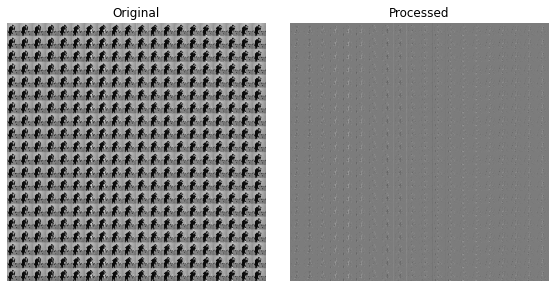

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda
from skimage import io

# read image and normalize
# image = io.imread('photographer.png').astype(np.float32)
image = io.imread("../codes/image_processing/sobel_v_convolution/photographer.png").astype(np.float32)
image = np.tile(image, (20, 20))
image -= np.min(image)
image /= np.max(image)
image_shape = image.shape[0]

# Sobel filter for vertical edges
tmp = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float32)
sobel_v_filter = (1. / 4) * np.array(tmp, dtype=np.float32)

filter_height, filter_width = sobel_v_filter.shape
filter_height_halved = filter_height // 2
filter_width_halved = filter_width // 2

# get shape of input image, allocate memory for output to which result can be copied to
edges_sobel_v = np.zeros_like(image)


threads_per_block = (16, 16)
blocks_per_grid_x = int(np.ceil(image_shape / threads_per_block[0]))
blocks_per_grid_y = int(np.ceil(image_shape / threads_per_block[1]))
blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

# filter vertical edges with sobel_v_filter
# filter2d_gpu[blocks_per_grid, threads_per_block](image, sobel_v_filter, edges_sobel_v)
print("CPU:")
resCPU = %timeit -n 2 -r 10 -o filter2d_cpu(image, sobel_v_filter, edges_sobel_v)
print("GPU:")
resGPU = %timeit -n 2 -r 10 -o filter2d_gpu[blocks_per_grid, threads_per_block](image, sobel_v_filter, edges_sobel_v)

# ignore edges, which are not a valid result
edges_sobel_v = edges_sobel_v[filter_height_halved:-filter_height_halved,
                filter_width_halved:-filter_width_halved]

# print min- and max-values for comparison with reference implementation
print("min pixel value: " + str(np.min(edges_sobel_v)))
print("max pixel value: " + str(np.max(edges_sobel_v)))

# show images
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 4))
axes[0].imshow(image, cmap=plt.cm.gray)
axes[0].set_title('Original')
axes[1].imshow(edges_sobel_v, cmap=plt.cm.gray)
axes[1].set_title('Processed')
for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()